In [1]:
import numpy as np
import pandas as pd

In [2]:
'''
import csv
s = set()
master = []
temp = []
tracker = 1
with open('Gamble_predict.csv', mode = 'r') as csvfile:
    file = csv.reader(csvfile)
    for lines in file:
        if tracker % 4 == 1:
            master.append(temp.copy())
            temp.clear()
        else:
            temp.extend(lines[:-1])
            for i in lines[:-1]:
                if i not in s:
                    s.add(i)
        tracker+=1

df = pd.DataFrame(master[1:], columns= ['(0,0)', '(0,1)','(0,2)','(0,3)','(0,4)','(1,0)','(1,1)','(1,2)','(1,3)','(1,4)','(2,0)','(2,1)','(2,2)','(2,3)','(2,4)'])
df.head()
'''

"\nimport csv\ns = set()\nmaster = []\ntemp = []\ntracker = 1\nwith open('Gamble_predict.csv', mode = 'r') as csvfile:\n    file = csv.reader(csvfile)\n    for lines in file:\n        if tracker % 4 == 1:\n            master.append(temp.copy())\n            temp.clear()\n        else:\n            temp.extend(lines[:-1])\n            for i in lines[:-1]:\n                if i not in s:\n                    s.add(i)\n        tracker+=1\n\ndf = pd.DataFrame(master[1:], columns= ['(0,0)', '(0,1)','(0,2)','(0,3)','(0,4)','(1,0)','(1,1)','(1,2)','(1,3)','(1,4)','(2,0)','(2,1)','(2,2)','(2,3)','(2,4)'])\ndf.head()\n"

In [3]:
df = pd.read_csv('New_Gambler.csv', skiprows=[191, 192, 193, 286, 287, 288])
df = df.drop(['timestamp','Unnamed: 16', 'Unnamed: 17'], axis = 1)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,j,9,q,c,p,10,v,j,q,j,k,9,k,k,v
1,10,e,j,e,j,c,q,j,q,e,q,d,9,10,q
2,p,q,10,p,v,j,f,q,a,9,10,a,a,9,e
3,v,p,k,9,e,k,9,j,q,f,10,k,9,10,9
4,v,a,k,f,j,j,9,j,k,e,a,9,f,9,q


In [4]:
'''
df = df.drop(df[df.eq("").any(axis=1)].index)
df.head()
'''

'\ndf = df.drop(df[df.eq("").any(axis=1)].index)\ndf.head()\n'

In [5]:
df.stack().value_counts()

9     645
j     562
q     497
10    489
a     478
k     427
e     312
f     311
v     285
p     275
c     127
d      78
h       8
o       4
`0      1
jh      1
Name: count, dtype: int64

In [6]:
#df = df[~df.isin(["`0", 'jh']).any(axis = 1)]

In [7]:
df = df.replace({'a':0, 'c':1, 'd':2, 'e':3, 'f':4, 'p':5, 'j':6, 'k':7, 'q':8, '9':9, '10':10, 'v':11, 'h':6, 'o':5, 'jh':6, "`0":9})
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,6,9,8,1,5,10,11,6,8,6,7,9,7,7,11
1,10,3,6,3,6,1,8,6,8,3,8,2,9,10,8
2,5,8,10,5,11,6,4,8,0,9,10,0,0,9,3
3,11,5,7,9,3,7,9,6,8,4,10,7,9,10,9
4,11,0,7,4,6,6,9,6,7,3,0,9,4,9,8


In [8]:
df.stack().value_counts()

9     646
6     571
8     497
10    489
0     478
7     427
3     312
4     311
11    285
5     279
1     127
2      78
Name: count, dtype: int64

In [9]:
import tensorflow as tf

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    #self.new_data = test_df.iloc[:6,:]

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
MAX_EPOCHS = 120

def compile_and_fit(model, window, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [15]:
wide_window = WindowGenerator(input_width=6, label_width=1, shift=1)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32), #, return_sequences=True
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=len(df.columns))
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/120
7/7 [==============================] - 1s 37ms/step - loss: 48.4066 - mean_absolute_error: 6.1590 - val_loss: 47.2108 - val_mean_absolute_error: 6.0910
Epoch 2/120
7/7 [==============================] - 0s 5ms/step - loss: 45.2483 - mean_absolute_error: 5.9456 - val_loss: 42.5935 - val_mean_absolute_error: 5.7563
Epoch 3/120
7/7 [==============================] - 0s 5ms/step - loss: 39.0726 - mean_absolute_error: 5.5177 - val_loss: 34.0785 - val_mean_absolute_error: 5.1406
Epoch 4/120
7/7 [==============================] - 0s 5ms/step - loss: 28.6475 - mean_absolute_error: 4.6915 - val_loss: 21.2567 - val_mean_absolute_error: 4.0233
Epoch 5/120
7/7 [==============================] - 0s 5ms/step - loss: 16.2206 - mean_absolute_error: 3.4668 - val_loss: 14.1364 - val_mean_absolute_error: 2.9522
Epoch 6/120
7/7 [==============================] - 0s 5ms/step - loss: 13.8580 - mean_absolute_error: 2.9311 - val_loss: 13.0577 - val_mean_absolute_error: 2.8256
Epoch 7/120
7/7 [====

In [16]:
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 11.1870 - mean_absolute_error: 2.7780


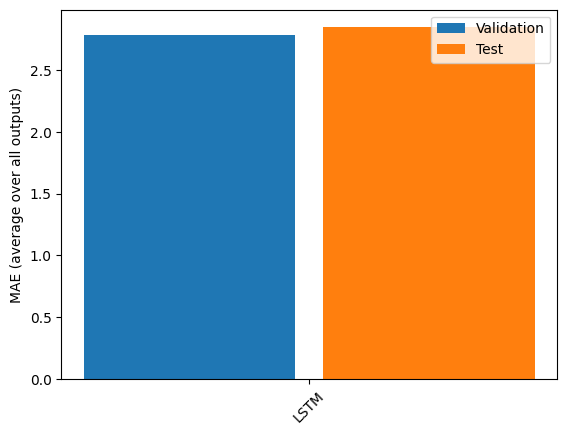

In [17]:
import matplotlib.pyplot as plt
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [18]:
test_df.iloc[:8,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
255,7,11,6,0,8,10,9,9,6,10,1,11,6,8,4
256,9,9,6,3,8,0,0,0,9,11,7,4,8,7,0
257,7,11,9,11,4,6,9,1,4,0,5,11,6,9,5
258,3,2,6,10,5,7,7,9,2,10,8,7,1,8,9
259,6,5,6,10,10,3,9,9,2,4,8,4,7,8,9
260,4,5,0,11,9,6,9,3,4,5,10,7,10,9,8
261,3,0,0,9,8,0,8,3,5,11,10,0,3,10,10
262,8,9,3,7,3,7,6,8,9,11,10,2,11,11,6


In [19]:
@property
def example_2(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  '''
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result
'''
  return self.make_dataset(test_df.iloc[:7,:]) #HAS TO BE 7 OR ABOVE WITH 6 INPUT WIDTH
WindowGenerator.example_2 = example_2

widey = WindowGenerator(input_width=6, label_width=1, shift=1)
lstm_model.predict(widey.example_2)

1/1 [==============================] - 0s 182ms/step


array([[6.4907374, 5.7885766, 6.8100514, 6.514884 , 6.6174755, 7.174625 ,
        6.6531954, 6.4222536, 6.2430644, 6.692877 , 6.9504514, 6.8856587,
        6.425667 , 6.273662 , 6.3253317]], dtype=float32)

In [20]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=len(df.columns))
])

In [21]:
history = compile_and_fit(dense, wide_window)
val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Epoch 1/120
7/7 [==============================] - 0s 16ms/step - loss: 39.7821 - mean_absolute_error: 5.4445 - val_loss: 27.9355 - val_mean_absolute_error: 4.4937
Epoch 2/120
7/7 [==============================] - 0s 4ms/step - loss: 22.2025 - mean_absolute_error: 3.9435 - val_loss: 15.9539 - val_mean_absolute_error: 3.3539
Epoch 3/120
7/7 [==============================] - 0s 4ms/step - loss: 14.2787 - mean_absolute_error: 3.0993 - val_loss: 12.8872 - val_mean_absolute_error: 2.9274
Epoch 4/120
7/7 [==============================] - 0s 4ms/step - loss: 12.1484 - mean_absolute_error: 2.8682 - val_loss: 12.5683 - val_mean_absolute_error: 2.9748
Epoch 5/120
7/7 [==============================] - 0s 4ms/step - loss: 12.1149 - mean_absolute_error: 2.9084 - val_loss: 12.0000 - val_mean_absolute_error: 2.8895
Epoch 6/120
7/7 [==============================] - 0s 4ms/step - loss: 11.6403 - mean_absolute_error: 2.8376 - val_loss: 11.6455 - val_mean_absolute_error: 2.8339
Epoch 7/120
7/7 [====

In [22]:
dense.predict(widey.example_2)

1/1 [==============================] - 0s 65ms/step


array([[[6.6838646, 5.838786 , 6.364419 , 6.2779226, 7.4665694,
         7.5932264, 6.798988 , 6.0056963, 5.843717 , 7.0571513,
         7.171519 , 5.773772 , 7.1831174, 6.4026995, 6.747491 ],
        [6.815562 , 4.813784 , 6.4646425, 6.135036 , 6.715533 ,
         6.0868053, 6.903857 , 5.595894 , 5.686003 , 6.460435 ,
         5.820463 , 6.1378274, 6.5489974, 6.5188904, 6.04703  ],
        [6.602833 , 5.720772 , 7.145573 , 7.192375 , 6.5209527,
         7.0735316, 6.9355993, 6.5997367, 6.263742 , 6.9249916,
         6.977721 , 6.6770735, 7.099598 , 6.0944943, 6.596692 ],
        [6.094987 , 5.5483503, 5.8843594, 5.7015896, 5.7297845,
         5.5558777, 5.7385187, 5.499669 , 5.752776 , 5.3233542,
         6.794293 , 6.577603 , 6.89744  , 5.3053412, 5.587882 ],
        [5.9814897, 5.1867657, 5.835043 , 6.114191 , 5.396239 ,
         6.0672   , 5.322526 , 5.4189796, 5.112752 , 5.9690976,
         5.9690166, 5.387805 , 5.297778 , 4.998473 , 5.1126184],
        [6.028053 , 5.764105 , 6.60